# CM50270 Reinforcement Learning
## Coursework Part 2: Racetrack

In this exercise, you will implement and compare the performance of three reinforcement learning algorithms: On-Policy First-Visit Monte-Carlo Control, Sarsa, and Q-Learning.

**Total number of marks:** 40 marks.

**What to submit:** Your completed Jupyter notebook (.ipynb file) which should include **all** of your source code. Please **do not change the file name or compress/zip your submission**. Please do not include any identifying information on the files you submit. This coursework will be marked **anonymously**.

**Where to submit:** CM50270 Moodle Page.

You are required to **work individually**. You are welcome to discuss ideas with others but you must design your own implementation and **write your own code**.

**Do not plagiarise**. Plagiarism is a serious academic offence. For details on what plagiarism is and how to avoid it, please visit the following webpage: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

If you are asked to use specific variable names, data-types, function signatures and notebook cells, **please ensure that you follow these instructions**. Not doing so will cause the automarker to reject your work, and will assign you a score of zero for that question. **If the automarker rejects your work because you have not followed the instructions, you may not get any credit for your work**.

Please **do not use any non-standard, third-party libraries** apart from numpy and matplotlib. In this part of the coursework, you should also use the `racetrack_env` file, which we have provided for you. **If we are unable to run your code because you have used unsupported external libraries, you may not get any credit for your work.**

Please remember to **save your work regularly**.

Please be sure to **restart the kernel and run your code from start-to-finish** (Kernel → Restart & Run All) before submitting your notebook. Otherwise, you may not be aware that you are using variables in memory that you have deleted.

Your total runtime must be less than **8 minutes** on the University's computers, and **written answer length limits** must be adhered to. Otherwise, you may not get credit for your work. You can run your code on the university's computers remotely using [UniDesk](https://bath.topdesk.net/tas/public/ssp/content/detail/knowledgeitem?unid=ff3266344c1d4eb2acb227cc9e3e1eee)

## The Racetrack Environment
We have implemented a custom environment called "Racetrack" for you to use during this piece of coursework. It is inspired by the environment described in the course textbook (Reinforcement Learning, Sutton & Barto, 2018, Exercise 5.12), but is not exactly the same.

### Environment Description
Consider driving a race car around a turn on a racetrack. In order to complete the race as quickly as possible, you would want to drive as fast as you can but, to avoid running off the track, you must slow down while turning.

In our simplified racetrack environment, the agent is at one of a discrete set of grid positions. The agent also has a discrete speed in two directions, $x$ and $y$. So the state is represented as follows:
$$(\text{position}_y, \text{position}_x, \text{velocity}_y, \text{velocity}_x)$$

The agent collects a reward of -1 at each time step, an additional -10 for leaving the track (i.e., ending up on a black grid square in the figure below), and an additional +10 for reaching the finish line (any of the red grid squares). The agent starts each episode in a randomly selected  grid-square on the starting line (green grid squares) with a speed of zero in both directions. At each time step, the agent can change its speed in both directions. Each speed can be changed by +1, -1 or 0, giving a total of nine actions. For example, the agent may increase its speed in the $x$ direction by -1 and its speed in the $y$ direction by +1. The agent's speed cannot be greater than +10 or less than -10 in either direction.

<img src="images/track_big.png" style="width: 600px;"/>


The agent's next state is determined by its current grid square, its current speed in two directions, and the changes it  makes to its speed in the two directions. This environment is stochastic. When the agent tries to change its speed, no change occurs (in either direction) with probability 0.2. In other words, 20% of the time, the agent's action is ignored and the car's speed remains the same in both directions.

If the agent leaves the track, it is returned to a random start grid-square and has its speed set to zero in both directions; the episode continues. An episode ends only when the agent transitions to a goal grid-square.



### Environment Implementation
We have implemented the above environment in the `racetrack_env.py` file, for you to use in this coursework. Please use this implementation instead of writing your own, and please do not modify the environment.

We provide a `RacetrackEnv` class for your agents to interact with. The class has the following methods:
- **`reset()`** - this method initialises the environment, chooses a random starting state, and returns it. This method should be called before the start of every episode.
- **`step(action)`** - this method takes an integer action (more on this later), and executes one time-step in the environment. It returns a tuple containing the next state, the reward collected, and whether the next state is a terminal state.
- **`render(sleep_time)`** - this method renders a matplotlib graph representing the environment. It takes an optional float parameter giving the number of seconds to display each time-step. This method is useful for testing and debugging, but should not be used during training since it is *very* slow. **Do not use this method in your final submission**.
- **`get_actions()`** - a simple method that returns the available actions in the current state. Always returns a list containing integers in the range [0-8] (more on this later).

In our code, states are represented as Python tuples - specifically a tuple of four integers. For example, if the agent is in a grid square with coordinates ($Y = 2$, $X = 3$), and is moving zero cells vertically and one cell horizontally per time-step, the state is represented as `(2, 3, 0, 1)`. Tuples of this kind will be returned by the `reset()` and `step(action)` methods.

There are nine actions available to the agent in each state, as described above. However, to simplify your code, we have represented each of the nine actions as an integer in the range [0-8]. The table below shows the index of each action, along with the corresponding changes it will cause to the agent's speed in each direction.

<img src="images/action_grid.png" style="width: 250px;"/>

For example, taking action 8 will increase the agent's speed in the $x$ direction, but decrease its speed in the $y$ direction.

### Racetrack Code Example
Below, we go through a quick example of using the `RaceTrackEnv` class.

First, we import the class, then create a `RaceTrackEnv` object called `env`. We then initialise the environment using the `reset()` method, and take a look at the initial state variable and the result of `plot()`.


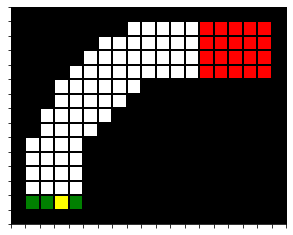

Initial State: (1, 3, 0, 0)


In [1]:
%matplotlib inline

# Set random seed to make example reproducable.
import numpy as np
import random
seed = 5
random.seed(seed)
np.random.seed(seed)

from racetrack_env import RacetrackEnv

# Instantiate environment object.
env = RacetrackEnv()

# Initialise/reset environment.
state = env.reset()
env.render()
print("Initial State: {}".format(state))

As you can see, `reset()` has returned a valid initial state as a four-tuple. The function `plot()` uses the same colour-scheme as described above, but also includes a yellow grid-square to indicate the current position of the agent.

Let's make the agent go upward by using `step(1)`, then inspect the result (recall that action `1` increments the agent's vertical speed while leaving the agent's horizontal speed unchanged).

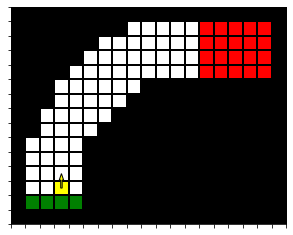

Next State: (2, 3, 1, 0), Reward: -1, Terminal: False


In [2]:
# Let us increase the agent's vertical speed (action 1).
next_state, reward, terminal = env.step(1)
env.render()
print("Next State: {}, Reward: {}, Terminal: {}".format(next_state, reward, terminal))

You can see that the agent has moved one square upwards, and now has a positive vertical speed (indicated by the yellow arrow). Let's set up a loop to see what happens if we take the action a few more times, causing it to repeatedly leave the track.

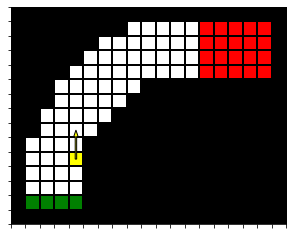

In [3]:
num_steps = 50
for t in range(num_steps) :
    next_state, reward, terminal = env.step(1)
    env.render()

## Exercise 1: On-Policy MC Control (8 Marks)

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using On-Policy First-Visit MC Control, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 5.4 p.101).

<img src="images/mc_control_algo.png" style="width: 650px;"/>

Please produce the following:
- A tabular **On-Policy First-Visit MC Control agent** which learns an optimal policy in the racetrack environment.
- An **average learning curve**. Your learning curve should plot the mean **undiscounted return** from many agents as a function of episodes. Please specify how many agents' performances you are averaging in the title of your plot. This should be a dynamic figure that we can produce by running your code. If you wish to use any kind of graph smoothing, please also include an un-smoothed version of your graph, and ensure that your smoothing method does not cause artifacts near the edges of the plot.

Please use the following parameter settings:
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from racetrack_env import RacetrackEnv

class OnPolMC:
    def __init__(self):
        # discount factor, gamma
        self.gamma = 0.9
        # exploratory action probability, epsilon
        self.explore_prob = 0.15
        # training of agent takes place over 150 episodes
        self.episodes_remaining = 150
        
        self.policy = {}
        self.q = {}
        self.returns = {}
        self.episode = []
        self.times_visited = {}
        self.rewards = []
        
        self.env = RacetrackEnv()
    
    def get_max_policy_action(self, state, actions):
        """
        returns the maximum action according to the policy, pi
        """
        action_probs = []
        # iterate through actions
        for action in actions:
            new_state_action = (state[0], state[1], state[2], state[3], action)
            # add new state-action pair to policy if it doesn't exist
            if new_state_action not in self.policy:
                self.policy[new_state_action] = 0
            action_probs.append([self.policy[new_state_action], action])
        max_actions = []
        for i in range(0, len(action_probs)):
            # create list of actions with maximum probability
            if action_probs[i][0] == max(action_probs)[0]:
                max_actions.append(action_probs[i][1])
        # if multiple actions have equal, maximum probability, choose max action at random
        max_policy = np.random.choice(max_actions)
        return max_policy
    
    def get_max_q_action(self, state, actions):
        """
        returns the maximum action according to Q
        """
        q_values = []
        # iterate through actions
        for action in actions:
            new_state_action = (state[0], state[1], state[2], state[3], action)
            # add new state-action pair to policy if it doesn't exist
            if new_state_action not in self.q:
                self.q[new_state_action] = 0
            q_values.append([self.q[new_state_action], action])
        max_qs = []
        for i in range(0, len(q_values)):
            # create list of actions with maximum value
            if q_values[i][0] == max(q_values)[0]:
                max_qs.append(q_values[i][1])
        # if multiple actions have equal, maximum probability, choose max action at random
        max_q = np.random.choice(max_qs)
        return max_q
    
    def generate_episode(self, start_state):
        """
        generates an episode following policy, pi
        """
        is_terminal = False
        state = start_state
        # cumulative reward for episode
        reward_episode = 0
        
        while not is_terminal:
            available_actions = self.env.get_actions()
            # select action following epsilon-greedy policy
            # random action with probability epsilon
            if np.random.uniform(0, 1) < self.explore_prob:
                action = np.random.choice(available_actions)
            # best action with probability 1 - epsilon
            else:
                action = self.get_max_policy_action(state, available_actions)
                
            new_state, reward, is_terminal = self.env.step(action)
            self.episode.append([state, available_actions, reward, action])
            # keeps track of how many times each state-action is visited in an episode
            if new_state not in self.times_visited:
                self.times_visited[(state[0], state[1], state[2], state[3], action)] = 1
            else:
                self.times_visited[(state[0], state[1], state[2], state[3], action)] += 1
            reward_episode += reward
            state = new_state
        self.episode.append([state, available_actions, reward, action])
        self.rewards.append(reward_episode)
        
    def monte_carlo(self):
        """
        performs first-visit Monte Carlo learning algorithm
        """
        while self.episodes_remaining > 0:
            start_state = self.env.reset()
            # generate episode following policy
            self.generate_episode(start_state)
            G = 0
            ep_num = len(self.episode) - 1
            # episode t = T
            episode_t1 = self.episode.pop()
            
            # iterate through each step of episode: t = T-1, T-2, ..., 0
            while ep_num > 0:
                episode_t = self.episode.pop()
                # update G
                G = G * self.gamma + episode_t1[2]
                state_action_t = (episode_t[0][0], episode_t[0][1], episode_t[0][2], episode_t[0][3], episode_t[3])
                # state-action is only updated for first visit in episode
                # elif only triggered if this is the first visit of state-action, otherwise counter is decremented
                if self.times_visited[state_action_t] > 1:
                    self.times_visited[state_action_t] -= 1
                elif self.times_visited[state_action_t] == 1:
                    if state_action_t not in self.returns:
                        self.returns[state_action_t] = []
                        self.q[state_action_t] = 0
                    #else:
                        #g = self.returns[state_action_t]
                        #g.append(G)
                        #self.returns[state_action_t] = g
                        # append G to returns for state-action pair
                    self.returns[state_action_t].append(G)

                    # update Q for average of state-action pair returns across all episodes
                    self.q[state_action_t] = sum(self.returns[state_action_t]) / len(self.returns[state_action_t])

                    # optimal A* is max action according to Q
                    A = self.get_max_q_action(state_action_t, episode_t[1])

                    # iterate through all actions for current state
                    for action in episode_t[1]:
                        new_state_action = (episode_t[0][0], episode_t[0][1], episode_t[0][2], episode_t[0][3], action)
                        if action == A:
                            self.policy[new_state_action] = 1 - self.explore_prob + (self.explore_prob/len(episode_t[1]))
                        else:
                            self.policy[new_state_action] = (self.explore_prob/len(episode_t[1]))
                ep_num -= 1
                episode_t1 = episode_t
            self.episode = []
            self.times_visited = {}
            self.episodes_remaining -= 1
        
    def get_rewards(self):
        """
        returns undiscounted returns for each episode
        """
        return self.rewards

# train 20 individual agents
num_agents = 20
all_rewards = []
averaged_rewards_mc = [0 for _ in range(0, 150)]
for i in range(0, num_agents):
    agent = OnPolMC()
    agent.monte_carlo()
    rewards = agent.get_rewards()
    all_rewards.append(rewards)

Text(0, 0.5, 'Undiscounted return')

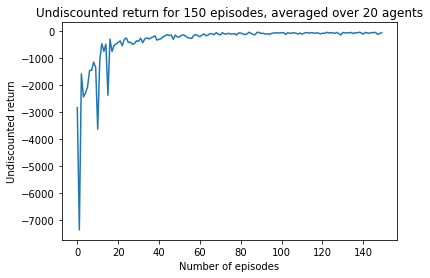

In [5]:
# Please write your code for Exercise 1 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your MC agent and plot your average learning curve here.
# Do NOT delete this cell.
for k in range(0, len(averaged_rewards_mc)):
    total = 0
    for j in range(0, len(all_rewards)):
        total += all_rewards[j][k]
    averaged_rewards_mc[k] = total / len(all_rewards)
plt.plot(averaged_rewards_mc)
plt.title("Undiscounted return for 150 episodes, averaged over {} agents".format(num_agents))
plt.xlabel("Number of episodes")
plt.ylabel("Undiscounted return")

## Exercise 2: Sarsa (4 Marks)

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using the Sarsa algorithm, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.4 p.129).

<img src="images/sarsa_algo.png" style="width: 650px;"/>

Please produce the following:

- A tabular **Sarsa agent** which learns an optimal policy in the racetrack environment.
- An **average learning curve**. Your learning curve should plot the mean **undiscounted return** from many agents as a function of episodes. Please specify how many agents' performances you are averaging in the title of your plot. This should be a dynamic figure that we can produce by running your code. If you wish to use any kind of graph smoothing, please also include an un-smoothed version of your graph, and ensure that your smoothing method does not cause artifacts near the edges of the plot.

Please use the following parameter settings:
- Step size parameter $\alpha = 0.2$.
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from racetrack_env import RacetrackEnv

class Sarsa:
    def __init__(self):
        # step size parameter, alpha
        self.step_size = 0.2
        # discount factor, gamma
        self.gamma = 0.9
        # exploratory action probability, epsilon
        self.explore_prob = 0.15
        # 150 episodes to train agent
        self.episodes_remaining = 150
        
        self.q = {}
        self.returns = {}
        self.rewards = []
        
        self.env = RacetrackEnv()
    
    def choose_action(self, state, actions):
        """
        returns the maximum action according to Q
        """
        q_values = []
        for action in actions:
            new_state_action = (state[0], state[1], state[2], state[3], action)
            if new_state_action not in self.q:
                self.q[new_state_action] = 0
            q_values.append([self.q[new_state_action], action])
        max_qs = []
        for i in range(0, len(q_values)):
            if q_values[i][0] == max(q_values)[0]:
                max_qs.append(q_values[i][1])
        max_q = np.random.choice(max_qs)
        return max_q
        
    def sarsa(self):
        """
        performs on-policy Sarsa learning algorithm
        """
        while self.episodes_remaining > 0:
            is_terminal = False
            start_state = self.env.reset()
            state = start_state
            reward_episode = 0
            
            # choose A from S using epsilon-greedy policy
            available_actions = self.env.get_actions()
            if np.random.uniform(0, 1) < self.explore_prob:
                action = np.random.choice(available_actions)
            else:
                action = self.choose_action(state, available_actions)
                
            while not is_terminal:
                # take A, observe R & S'
                new_state, reward, is_terminal = self.env.step(action)
                #if self.episodes_remaining == 1:
                #    self.env.render()
                reward_episode += reward
                
                # choose A' from S' using epsilon-greedy policy
                available_actions = self.env.get_actions()
                if np.random.uniform(0, 1) < self.explore_prob:
                    new_action = np.random.choice(available_actions)
                else:
                    # action is one with maximum probability
                    new_action = self.choose_action(new_state, available_actions)
                
                old_state_action = (state[0], state[1], state[2], state[3], action)
                new_state_action = (new_state[0], new_state[1], new_state[2], new_state[3], new_action)
                if old_state_action not in self.q:
                    self.q[old_state_action] = 0
                if new_state_action not in self.q:
                    self.q[new_state_action] = 0

                # update Q on-policy using new action selected from epsilon-greedy policy
                old_q = self.q[old_state_action]
                self.q[old_state_action] = old_q + self.step_size * (reward + self.gamma * self.q[new_state_action] - old_q)
                state = new_state
                action = new_action
            self.rewards.append(reward_episode)
            self.episodes_remaining -= 1
        
    def get_rewards(self):
        """
        returns undiscounted returns for each episode
        """
        return self.rewards

# train 20 individual agents    
num_agents = 20
all_rewards = []
averaged_rewards_sarsa = [0 for _ in range(0, 150)]
for i in range(0, num_agents):
    agent = Sarsa()
    agent.sarsa()
    rewards = agent.get_rewards()
    all_rewards.append(rewards)

Text(0, 0.5, 'Undiscounted return')

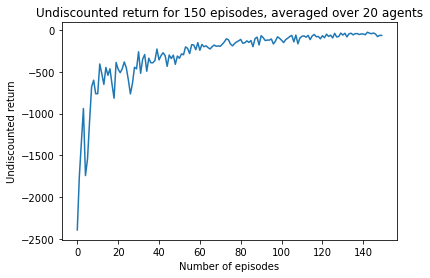

In [7]:
# Please write your code for Exercise 2 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your sarsa agent and plot your average learning curve here.
# Do NOT delete this cell.
for k in range(0, len(averaged_rewards_sarsa)):
    total = 0
    for j in range(0, len(all_rewards)):
        total += all_rewards[j][k]
    averaged_rewards_sarsa[k] = total / len(all_rewards)
plt.plot(averaged_rewards_sarsa)
plt.title("Undiscounted return for 150 episodes, averaged over {} agents".format(num_agents))
plt.xlabel("Number of episodes")
plt.ylabel("Undiscounted return")

## Exercise 3: Q-Learning (4 Marks)

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using the Q-Learning algorithm, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131).

<img src="images/q_learning_algo.png" style="width: 650px;"/>

Please produce the following:

- A tabular **Q-Learning agent** which learns an optimal policy in the racetrack environment.
- An **average learning curve**. Your learning curve should plot the mean **undiscounted return** from many agents as a function of episodes. Please specify how many agents' performances you are averaging in the title of your plot. This should be a dynamic figure that we can produce by running your code. If you wish to use any kind of graph smoothing, please also include an un-smoothed version of your graph, and ensure that your smoothing method does not cause artifacts near the edges of the plot.

Please use the following parameter settings:
- Step size parameter $\alpha = 0.2$.
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

Hint: Your Q-Learning implementation is likely to be similar to your Sarsa implementation. Think hard about where these two algorithms differ.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from racetrack_env import RacetrackEnv

class QLearning:
    def __init__(self):
        # step size parameter, alpha
        self.step_size = 0.2
        # discount factor, gamma
        self.gamma = 0.9
        # exploratory action probability, epsilon
        self.explore_prob = 0.15
        # 150 episodes to train agent
        self.episodes_remaining = 150
        
        self.q = {}
        self.returns = {}
        self.rewards = []
        
        self.env = RacetrackEnv()
    
    def choose_action(self, state, actions):
        """
        returns the maximum action according to Q
        """
        q_values = []
        for action in actions:
            new_state_action = (state[0], state[1], state[2], state[3], action)
            if new_state_action not in self.q:
                self.q[new_state_action] = 0
            q_values.append([self.q[new_state_action], action])
        max_qs = []
        for i in range(0, len(q_values)):
            if q_values[i][0] == max(q_values)[0]:
                max_qs.append(q_values[i][1])
        max_q = np.random.choice(max_qs)
        return max_q
        
    def q_learning(self):
        """
        performs off-policy Q-learning learning algorithm
        """
        while self.episodes_remaining > 0:
            is_terminal = False
            start_state = self.env.reset()
            state = start_state
            reward_episode = 0
                
            while not is_terminal:
                # choose A from S using epsilon-greedy policy
                available_actions = self.env.get_actions()
                if np.random.uniform(0, 1) < self.explore_prob:
                    action = np.random.choice(available_actions)
                else:
                    action = self.choose_action(state, available_actions)
                
                # take A, observe R & S'
                new_state, reward, is_terminal = self.env.step(action)
                reward_episode += reward
                #if self.episodes_remaining == 1:
                #    self.env.render()
                
                old_state_action = (state[0], state[1], state[2], state[3], action)
                
                if old_state_action not in self.q:
                    self.q[old_state_action] = 0

                old_q = self.q[old_state_action]
                # always choose max action for updating Q
                max_action = self.choose_action(new_state, self.env.get_actions())
                max_state_action = (new_state[0], new_state[1], new_state[2], new_state[3], max_action)
                if max_state_action not in self.q:
                    self.q[max_state_action] = 0
                    
                # update Q off-policy using optimal action
                self.q[old_state_action] = old_q + self.step_size * (reward + self.gamma * self.q[max_state_action] - old_q)
                state = new_state
            self.rewards.append(reward_episode)
            self.episodes_remaining -= 1
        
    def get_rewards(self):
        """
        returns undiscounted returns for each episode
        """
        return self.rewards

# train 20 individual agents
num_agents = 20
all_rewards = []
averaged_rewards_q = [0 for _ in range(0, 150)]
for i in range(0, num_agents):
    agent = QLearning()
    agent.q_learning()
    rewards = agent.get_rewards()
    all_rewards.append(rewards)

Text(0, 0.5, 'Undiscounted return')

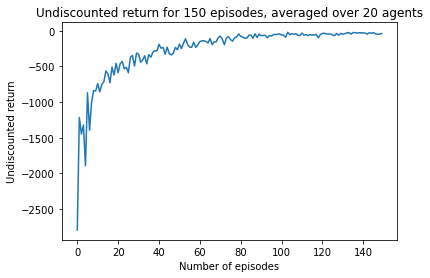

In [9]:
# Please write your code for Exercise 3 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your q-learning agent agent and plot your average learning curve here.
# Do NOT delete this cell.
for k in range(0, len(averaged_rewards_q)):
    total = 0
    for j in range(0, len(all_rewards)):
        total += all_rewards[j][k]
    averaged_rewards_q[k] = total / len(all_rewards)
plt.plot(averaged_rewards_q)
plt.title("Undiscounted return for 150 episodes, averaged over {} agents".format(num_agents))
plt.xlabel("Number of episodes")
plt.ylabel("Undiscounted return")

## Exercise 4: Comparison & Discussion (8 Marks)

Please produce a plot which shows the data from your previous three graphs plotted together on the same set of axes. Be sure to include plot elements such as [axis labels, titles](https://matplotlib.org/3.3.3/tutorials/text/text_intro.html), and a [legend](https://matplotlib.org/3.3.3/tutorials/intermediate/legend_guide.html), so that it is clear which data series corresponds to the performance of which agent. **If we are not able to easily interpret your plots, you may not get any credit for your work.**

Please note that **you should not re-train your agents from scratch**. You should re-use your results from the previous exercises.

To improve the visual clarity of your graphs, you may wish to apply some kind of cropping or smoothing. If you choose to do this, please also include an un-altered version of your graph. Please ensure that any graph smoothing method you use does not cause artifacts near the edges of the plot.

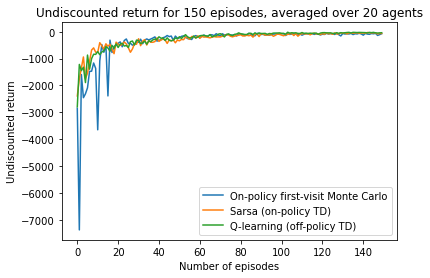

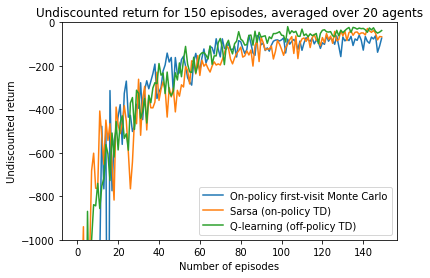

In [10]:
# Please write your code for Exercise 4 in this cell or in as many cells as you want ABOVE this cell.
# You should plot your combined graph here, clearly showing each of the average learning curves of your three agents.
# Do NOT delete this cell.
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.plot(averaged_rewards_mc)
ax1.plot(averaged_rewards_sarsa)
ax1.plot(averaged_rewards_q)
plt.title("Undiscounted return for 150 episodes, averaged over {} agents".format(num_agents))
plt.xlabel("Number of episodes")
plt.ylabel("Undiscounted return")
plt.legend(["On-policy first-visit Monte Carlo", "Sarsa (on-policy TD)", "Q-learning (off-policy TD)"], loc='lower right')
fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.plot(averaged_rewards_mc)
ax2.plot(averaged_rewards_sarsa)
ax2.plot(averaged_rewards_q)
plt.title("Undiscounted return for 150 episodes, averaged over {} agents".format(num_agents))
plt.xlabel("Number of episodes")
plt.ylabel("Undiscounted return")
plt.ylim([-1000, 0])
plt.legend(["On-policy first-visit Monte Carlo", "Sarsa (on-policy TD)", "Q-learning (off-policy TD)"], loc='lower right')

In **eight sentences** or fewer, please discuss the following:
- The performance of your different agents.
- Why each of your agents performed differently.
- Explain the differences you saw, and expected to see, between the performances and polices of your Sarsa and Q-Learning agents.
- What could be done to improve the performance of your agents?

The on-policy first-visit Monte Carlo (MC), Sarsa (on-policy temporal difference (TD)), and Q-learning (off-policy TD) training algorithms all display a plateau of the undiscounted return after around 80 episodes, but the MC displays significantly lower return than the other two methods for the first 25 episodes, before gaining the higher average returns for episodes 25-40 and dropping to the lowest return for the remaining episodes. This is because the backup diagram for MC covers the entire episode rather than updating after each step as in TD methods, which has the consequence that MC learns slower as the agent must wait until the end of the episode before any updates to the policy or state-action values take place, meaning that all actions are effectively random for the first epsiode, hence the initial large negative reward. The small region where MC performs best may be due to the fact that the entire episode is considered when backing up and so will learn an optimum route faster than TD methods in this middle stage once the disadvantages of slow updates are overcome. I expected to see that Sarsa would outperform Q-learning towards the end of the 150 episodes, because Q-learning always updates using the maximum action which means that it will always learn the optimal policy, which should be as close to the apex as possible in the racetrack example, and therefore when exploratory actions are selected, this will introduce more occurrences of negative rewards as the agent sometimes leaves the race track. Sarsa on the other hand updates using the action selected using the epsilon-greedy policy, and therefore takes random actions into account when updating, which ensures that Sarsa will learn a more conservative policy that would likely be down the centre of the racetrack. Therefore, although it may be sub-optimal, the agent is less likely to fall off the racetrack and so I would have expected the total return to be higher, but this is not the case. Sarsa and Q-learning could be improved by introducing eligibility traces so that the state-action values are updated for all those previously visited by the agent, and MC would benefit from some regular updating, especially early on in in the learning process.

## Exercise 5: Modified Q-Learning Agent (16 Marks)
### Exercise 5a: Implementation
In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using the Q-Learning algorithm, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131).

<img src="images/q_learning_algo.png" style="width: 650px;"/>

In order to score high marks in this exercise, you will need to extend your solution beyond a simple Q-Learning agent to achieve more efficient learning (i.e., using fewer interactions with the environment). Ideas for improving your agent will have been discussed in lectures, and can be found in the course textbook (Reinforcement Learning, Sutton & Barto, 2018). However you go about improving your agent, it must still use **tabular Q-Learning** at its core.

Please produce the following:
- A tabular **Q-Learning agent**, with whatever modifications you believe are reasonable in order to acheieve better performance in the Racetrack domain.
- An **average learning curve**. Your learning curve should plot the mean **undiscounted return** from many agents as a function of episodes. Please specify how many agents' performances you are averaging in the title of your plot. This should be a dynamic figure that we can produce by running your code. If you wish to use any kind of graph smoothing, please also include an un-smoothed version of your graph, and ensure that your smoothing method does not cause artifacts near the edges of the plot.

Please use the following parameter settings:
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

You may adjust all other parameters as you see fit.

In [11]:
# Please write your code for Exercise 5a in this cell or in as many cells as you want ABOVE this cell.
# You should implement your modified q-learning agent agent and plot your average learning curve here.
# Do NOT delete this cell.

import numpy as np
import matplotlib.pyplot as plt
from racetrack_env import RacetrackEnv

class WatkinsQ:
    def __init__(self):
        self.step_size = 0.2
        self.gamma = 0.9
        self.explore_prob = 0.15
        self.eligibility_decay = 0.75
        self.episodes_remaining = 150
        
        self.q = {}
        self.e = {}
        self.returns = {}
        self.rewards = []
        self.episode = []
        
        self.env = RacetrackEnv()
    
    def choose_action(self, state, actions):
        q_values = []
        for action in actions:
            new_state_action = (state[0], state[1], state[2], state[3], action)
            if new_state_action not in self.q:
                self.q[new_state_action] = 0
                self.e[new_state_action] = 0
            q_values.append([self.q[new_state_action], action])
        max_qs = []
        for i in range(0, len(q_values)):
            if q_values[i][0] == max(q_values)[0]:
                max_qs.append(q_values[i][1])
        max_q = np.random.choice(max_qs)
        return max_q
        
    def q_lambda(self):
        while self.episodes_remaining > 0:
            is_terminal = False
            start_state = self.env.reset()
            state = start_state
            reward_episode = 0
            # initialise S, A
            available_actions = self.env.get_actions()
            action = np.random.choice(available_actions)
                
            while not is_terminal:
                old_state_action = (state[0], state[1], state[2], state[3], action)
                self.episode.append(old_state_action)
                
                # take A, observe R & S'
                new_state, reward, is_terminal = self.env.step(action)
                reward_episode += reward
                
                # choose A' from S'
                available_actions = self.env.get_actions()
                if np.random.uniform(0, 1) < self.explore_prob:
                    new_action = np.random.choice(available_actions)
                else:
                    # action is one with maximum probability
                    new_action = self.choose_action(new_state, available_actions)
                
                # calculate A*
                best_action = self.choose_action(new_state, available_actions)
                
                old_state_action = (state[0], state[1], state[2], state[3], action)
                new_state_action = (new_state[0], new_state[1], new_state[2], new_state[3], new_action)
                best_state_action = (new_state[0], new_state[1], new_state[2], new_state[3], best_action)
                if old_state_action not in self.q:
                    self.q[old_state_action] = 0
                    self.e[old_state_action] = 0
                if new_state_action not in self.q:
                    self.q[new_state_action] = 0
                    self.e[new_state_action] = 0
                if best_state_action not in self.q:
                    self.q[best_state_action] = 0
                    self.e[best_state_action] = 0
                old_q = self.q[old_state_action]
                
                # calculate delta
                delta = reward + self.gamma * self.q[best_state_action] - old_q
                
                # update e
                self.e[old_state_action] += 1
                
                for state_action in self.episode:
                    # update Q(S,A)
                    self.q[state_action] += self.step_size * delta * self.e[state_action]
                    
                    # update e
                    if new_action == best_action:
                        self.e[state_action] = self.gamma * self.eligibility_decay * self.e[state_action]
                    else:
                        self.e[state_action] = 0
                
                state = new_state
                action = new_action
            self.rewards.append(reward_episode)
            self.episodes_remaining -= 1
            self.episode = []
        
    def get_rewards(self):
        return self.rewards
    
num_agents = 20
all_rewards = []
averaged_rewards_q_lambda = [0 for _ in range(0, 150)]
for i in range(0, num_agents):
    agent = WatkinsQ()
    agent.q_lambda()
    rewards = agent.get_rewards()
    all_rewards.append(rewards)

### Exercise 5b: Comparison & Discussion

Please produce a plot which shows the performance of your original Q-Learning agent and your modified Q-Learning agent. Be sure to include plot elements such as [axis labels, titles](https://matplotlib.org/3.3.3/tutorials/text/text_intro.html), and a [legend](https://matplotlib.org/3.3.3/tutorials/intermediate/legend_guide.html), so that it is clear which data series corresponds to the performance of which agent. **If we are not able to easily interpret your plots, you may not get any credit for your work.**

Please note that **you should not re-train your agents from scratch**. You should re-use your results from the previous exercises.

To improve the visual clarity of your graphs, you may wish to apply some kind of cropping or smoothing. If you choose to do this, please also include an un-altered version of your graph. Please ensure that any graph smoothing method you use does not cause artifacts near the edges of the plot.

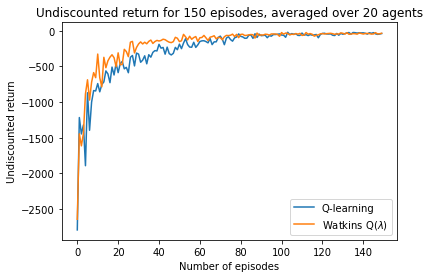

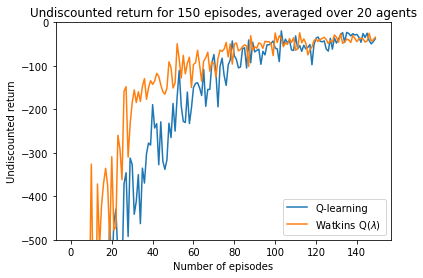

In [12]:
# Please write your code for Exercise 5b in this cell or in as many cells as you want ABOVE this cell.
# You should plot your combined graph here, clearly showing the average learning curves of your
# original and modified Q-Learning agents.
# Do NOT delete this cell.
for k in range(0, len(averaged_rewards_q_lambda)):
    total = 0
    for j in range(0, len(all_rewards)):
        total += all_rewards[j][k]
    averaged_rewards_q_lambda[k] = total / len(all_rewards)

fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.plot(averaged_rewards_q)
ax1.plot(averaged_rewards_q_lambda)
plt.title("Undiscounted return for 150 episodes, averaged over {} agents".format(num_agents))
plt.xlabel("Number of episodes")
plt.ylabel("Undiscounted return")
plt.legend(["Q-learning", "Watkins Q($\lambda$)"], loc='lower right')
fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.plot(averaged_rewards_q)
ax2.plot(averaged_rewards_q_lambda)
plt.title("Undiscounted return for 150 episodes, averaged over {} agents".format(num_agents))
plt.xlabel("Number of episodes")
plt.ylabel("Undiscounted return")
plt.ylim([-500, 0])
plt.legend(["Q-learning", "Watkins Q($\lambda$)"], loc='lower right')

In **eight sentences** or fewer, please discuss the following:
- The modifications that you have made to your agent beyond implementing basic Q-Learning.
- The effects you expected your additions to have, and the extent to which your expectations were met.
- Further modifications you believe may enhance the performance of your agent, or changes you would make if you had more time.

Please note that **your implementation and discussion will be assessed jointly**. This means that, in order to score highly, you will need to correctly implement appropriate modifications to your agent **AND** discuss them well.

Watkins's Q($\lambda$) method is implemented (Sutton & Barto, 1st.ed, chap.7.6) which, at each step of the episode, updates all the previous steps by applying a weighting $\lambda$ (eligibility decay) so that the most recent steps have a larger weighting than the early ones. The value $e$ (eligibility trace) ensures that $Q(S,A)$ is not updated if a random action was taken by the agent and not the optimal action. This maintains one of the key principals of Q-learning where state-action value updates use the optimal action and any random actions taken do not affect the state-action values, but is extended to include backups of all state-action pairs that were taken between exploratory actions. Setting $\lambda = 1$ makes the algorithm tend to Monte Carlo with a backup of the full episode and $\lambda = 0$ transforms it into a TD(0) algorithm, only updating the previous step, combining the benefits of TD methods where updates take place after every step, and MC methods where a backup is done of all previous steps, both of which ensure more rapid learning of the optimal path. Setting a low $\lambda$ produces a returns graph that looks almost identical to Q-learning and a higher $\lambda$ ensures the state values converge quicker, obtaining higher rewards for the early episodes before convergence is reached. The above graph used a value of $\lambda=0.75$ and the returns graph shows the agent obtaining higher return over particularly the first 80 episodes, when trained using Watkins's Q($\lambda$) compared to Q-learning. The effect is particularly noticable over the first 60 episodes where Watkins's Q($\lambda$) shows that the gradient of the graph is initially steeper, indicating, as expected, more rapid learning due to all previous states being updated after each move so that the optimum path is found more efficiently. A further modification could be to implement Peng's Q($\lambda$) (Sutton & Barto, 1st.ed, chap.7.6) which is an adaptation to Watkins's Q($\lambda$) that does not set the eligibilty trace to zero when an exploratory action is taken, making it similar to Sarsa in that random exploratory actions are included in the learning, and thus the agent learning can potentially take place quicker.